# Experiments

TODO: Use 5-fold cross validation.

## Dataset
- `dev` only
- `dev` and part of `devtest` using `train_test_split`
- use same model for `normal` and `hard`, i.e. concat `dev` and `dev-hard`

## Text cleaning
- just `word_tokenize`
- remove punctuations
- remove stop words
- use Porter stemmer

## Feature engineering

- number of unique overlapping unigrams
- number of overlapping unigrams (probably not much difference)

Always use edit distance

### Misc
- Compute feature correlation
- Visualize feature distribution as well as a scatter plot of the 2D features.

In [57]:
import pickle

import string
import editdistance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
punctuations = set(string.punctuation)
stopwords = set(nltk.corpus.stopwords.words('english'))
ps = nltk.PorterStemmer()

In [3]:
def load_file(path, skip_id=False, has_label=True):
    """
    has_label: also return label column if True
    return [['hello world', 'hi'], ['hi World', 'hello']]
    """
    first_lines = []
    second_lines = []
    if has_label:
        labels = []
    if skip_id:
        start_col_idx = 1
    else:
        start_col_idx = 0
    with open(path, 'rt') as f:
        for line in f:
            chunks = line.strip().split('\t')
            first = chunks[start_col_idx]
            second = chunks[start_col_idx + 1]
            first_lines.append(first)
            second_lines.append(second)
            
            if has_label:
                label = int(chunks[start_col_idx + 2])
                labels.append(label)
    if has_label:
        ret = pd.DataFrame({
            'line1': first_lines, 
            'line2': second_lines, 
            'is_paraphrase': labels
        })
    else:
        ret = pd.DataFrame({
            'line1': first_lines, 
            'line2': second_lines
        })
    return ret

In [41]:
def clean_text(text, remove_punkt=False, remove_stopwords=False, stem=False):
    tokens = word_tokenize(text.lower())
    if remove_punkt:
        tokens = [tok for tok in tokens if not tok in punctuations]
    if remove_stopwords:
        tokens = [tok for tok in tokens if not tok in stopwords]
    if stem:
        tokens = [ps.stem(tok) for tok in tokens]
    return tokens

In [5]:
def construct_features(first_lines, second_lines):
    # number of unique overlapping unigrams, edit distance
    features = np.empty((len(first_lines), 2))
    for idx, tup in enumerate(zip(first_lines, second_lines)):
        first, second = tup
        num_unigrams = len(set(first).intersection(second))
        edit_dist = editdistance.eval(first, second)
        features[idx, 0] = num_unigrams
        features[idx, 1] = edit_dist
    return features

In [6]:
def model_pipeline(X, y, X_val, y_val):
    """
    X, y: train; X_val, y_val: validation
    """
    model = MLPClassifier(max_iter=1000, random_state=0)
    model.fit(X, y)
    y_pred = model.predict(X)
    train_accu = accuracy_score(y, y_pred)
    print('Train accuray: {:4f}'.format(train_accu))
    y_val_pred = model.predict(X_val)
    val_accu = accuracy_score(y_val, y_val_pred)
    print('Validation accuracy: {:4f}'.format(val_accu))
    # construct confusion matrix on validation set
    conf_mat = confusion_matrix(y_val, y_val_pred)
    ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('True labels')
    
    ret = {
        'model': model,
        'train_accu': train_accu,
        'val_accu': val_accu,
        'conf_mat': ax
    }
    return ret

In [39]:
def run_experiment(train_df, val_df, call_clean_text=True, clean_text_kws=None):
    if call_clean_text:
        X = construct_features(train_df.line1.apply(clean_text, **clean_text_kws), 
                               train_df.line2.apply(clean_text, **clean_text_kws))
        X_val = construct_features(val_df.line1.apply(clean_text, **clean_text_kws),
                                   val_df.line2.apply(clean_text, **clean_text_kws))
    else:
        X = construct_features(train_df.line1, train_df.line2)
        X_val = construct_features(val_df.line1, val_df.line2)
        
    y = train_df.is_paraphrase
    y_val = val_df.is_paraphrase
    ret = model_pipeline(X, y, X_val, y_val)
    return ret

# Load data

In [8]:
dev = load_file('data/dev+devtest/dev.tsv')
devtest = load_file('data/dev+devtest/devtest.tsv')
test = load_file('data/test_no_labels.tsv', skip_id=True, has_label=False)
dev_hard = load_file('data/heldout-hard/dev.hard.tsv')
devtest_hard = load_file('data/heldout-hard/devtest.hard.tsv')
test_hard = load_file('data/heldout-hard/test.hard.tsv', has_label=False)

In [9]:
dev.head()

,line1,line2,is_paraphrase
0,I don't know what you're sayin'.,I don't know what you're talking about.,1
1,They're on the next flight home.,he's going home next flight.,1
2,Such stories.,the stories.,1
3,On your left!,in the left!,1
4,I don't think it's actually a good idea...,I don't think it's a good idea.,1


In [12]:
experiments = {}

# Baseline
- Use dev only, train different models for normal and hard
- Test on devtest
- No text cleaning, which means the string are parsed character by character

Train accuray: 0.841076
Validation accuracy: 0.813665


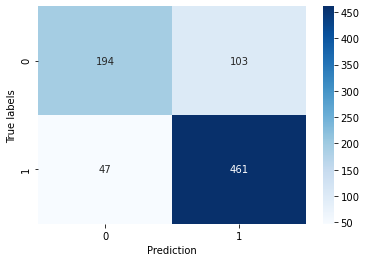

In [13]:
# normal
ret = run_experiment(dev, devtest, call_clean_text=False)
experiments['baseline'] = ret

Train accuray: 0.725000
Validation accuracy: 0.700000


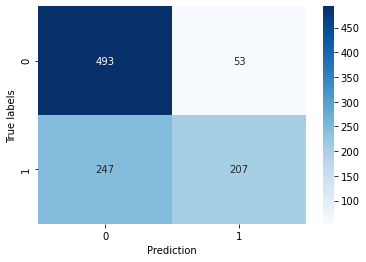

In [14]:
# hard
ret = run_experiment(dev_hard, devtest_hard, call_clean_text=False)
experiments['baseline_hard'] = ret

# With tokenization

Train accuray: 0.844743
Validation accuracy: 0.829814


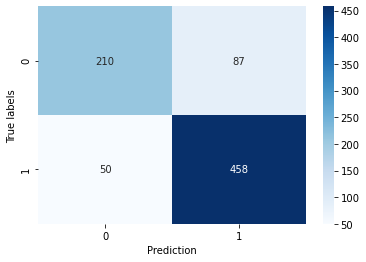

In [15]:
# normal
ret = run_experiment(dev, devtest, call_clean_text=True)
experiments['tokenized'] = ret

Train accuray: 0.689000
Validation accuracy: 0.668000


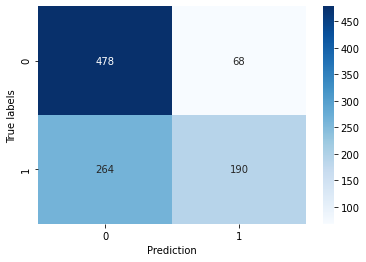

In [16]:
# hard
ret = run_experiment(dev_hard, devtest_hard, call_clean_text=True)
experiments['tokenized_hard'] = ret

Concat and `train_test_split` dev and devtest for more training data. From the result it looks like bigger datasets are better.

In [18]:
normal = pd.concat([dev, devtest])
hard = pd.concat([dev_hard, devtest_hard])
dev_big, devtest_small = train_test_split(normal, random_state=0)
dev_hard_big, devtest_hard_small = train_test_split(hard, random_state=0)

In [19]:
print(len(dev_hard), len(dev_hard_big))
dev_hard_big.head()

1000 1500


,line1,line2,is_paraphrase
45,A proposed Mahadayi River ( Mandovi River ) wa...,A proposed Mahadayi River ( Mandovi River ) wa...,1
937,Rıza Maksut İşman ( 1915 in Istanbul -- Decemb...,Rıza Maksut İşman ( 1915 in İzmir -- December ...,0
658,A Peri whose power is in her hair appears in E...,A Peri whose force appears in her hair is in E...,0
529,This made him the first 994nd grader to play f...,This made him the 994th first grader to play f...,0
895,The first or `` narrow '' system consists of r...,The first or `` red '' system consists of narr...,0


Train accuray: 0.842235
Validation accuracy: 0.837438


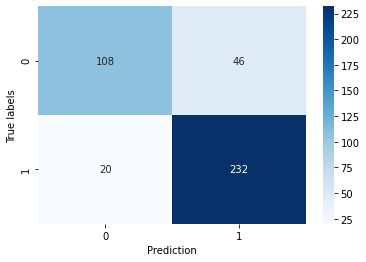

In [21]:
# normal
ret = run_experiment(dev_big, devtest_small, call_clean_text=True)
experiments['big'] = ret

Train accuray: 0.681333
Validation accuracy: 0.686000


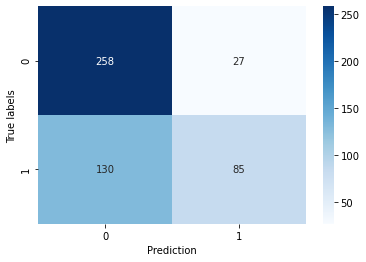

In [23]:
# hard
ret = run_experiment(dev_hard_big, devtest_hard_small, call_clean_text=True)
experiments['big_hard'] = ret

Train a single model for both normal and hard by concatenating all data. The results were actually worse, which might mean that the normal and hard version are very different.

Train accuray: 0.690099
Validation accuracy: 0.667770


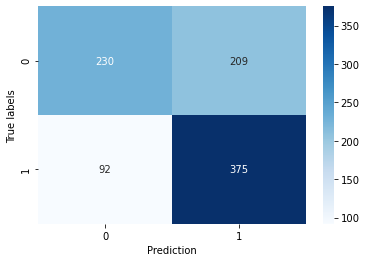

In [24]:
ret = run_experiment(
    pd.concat([dev_big, dev_hard_big]), 
    pd.concat([devtest_small, devtest_hard_small]), 
    call_clean_text=True)
experiments['combined'] = ret

Train accuray: 0.690099
Validation accuracy: 0.812808


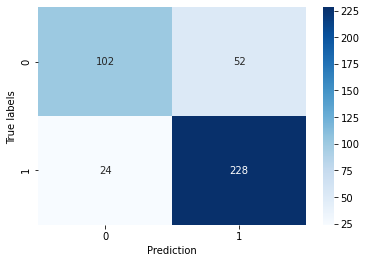

In [30]:
# evaluate performance separately
# the model has never seen devtest_small or devtest_hard_small
# okay to call run_experiment here since I set training to be deterministic
ret = run_experiment(
    pd.concat([dev_big, dev_hard_big]), 
    devtest_small,
    call_clean_text=True)
experiments['combined_normal'] = ret

Train accuray: 0.690099
Validation accuracy: 0.550000


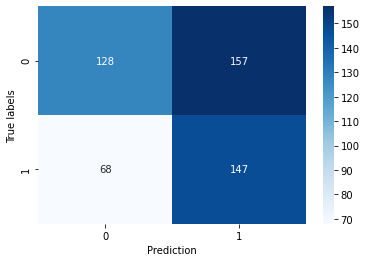

In [31]:
ret = run_experiment(
    pd.concat([dev_big, dev_hard_big]), 
    devtest_hard_small,
    call_clean_text=True)
experiments['combined_hard'] = ret

# Text cleaning
- Remove punctuations
- Remove stopwords
- Stem

Use the bigger sets.

Train accuray: 0.823336
Validation accuracy: 0.852217


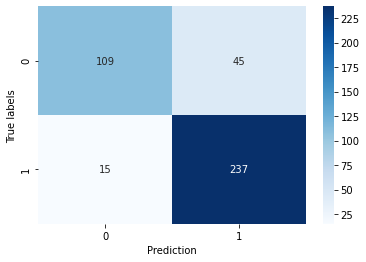

In [42]:
# normal
ret = run_experiment(dev_big, devtest_small, call_clean_text=True, 
                    clean_text_kws={'remove_punkt': True})
experiments['no_punkt'] = ret

Train accuray: 0.693333
Validation accuracy: 0.706000


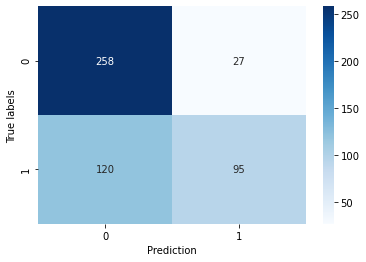

In [43]:
# hard
ret = run_experiment(dev_hard_big, devtest_hard_small, call_clean_text=True, 
                    clean_text_kws={'remove_punkt': True})
experiments['no_punkt_hard'] = ret

Train accuray: 0.775678
Validation accuracy: 0.812808


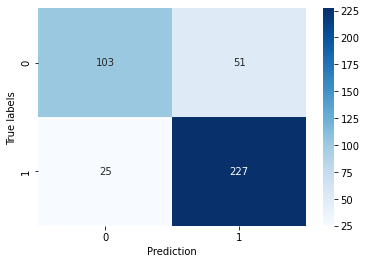

In [44]:
# normal
ret = run_experiment(dev_big, devtest_small, call_clean_text=True, 
                    clean_text_kws={'remove_punkt': True, 
                                    'remove_stopwords': True})
experiments['no_punkt_stopwords'] = ret

Train accuray: 0.712667
Validation accuracy: 0.742000


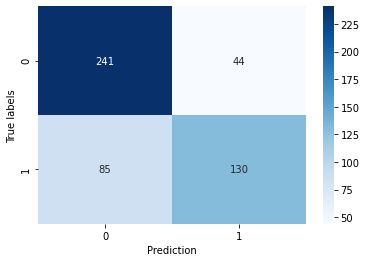

In [46]:
# hard
ret = run_experiment(dev_hard_big, devtest_hard_small, call_clean_text=True, 
                    clean_text_kws={'remove_punkt': True, 
                                    'remove_stopwords': True})
experiments['no_punkt_stopwords_hard'] = ret

Train accuray: 0.833196
Validation accuracy: 0.859606


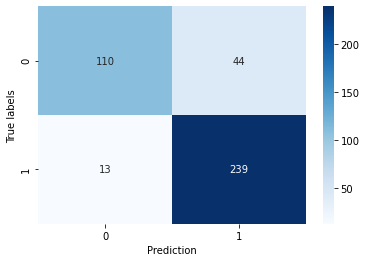

In [49]:
# normal
ret = run_experiment(dev_big, devtest_small, call_clean_text=True, 
                    clean_text_kws={'remove_punkt': True, 
                                    'stem': True})
experiments['no_punkt_stem'] = ret

Train accuray: 0.698000
Validation accuracy: 0.710000


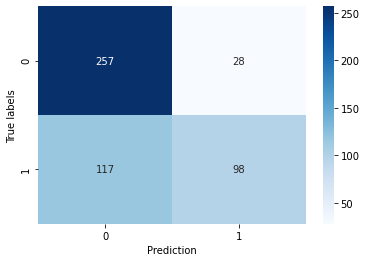

In [56]:
# hard
ret = run_experiment(dev_hard_big, devtest_hard_small, call_clean_text=True, 
                    clean_text_kws={'remove_punkt': True, 
                                    'stem': True})
experiments['no_punkt_stem_hard'] = ret

Train accuray: 0.794577
Validation accuracy: 0.817734


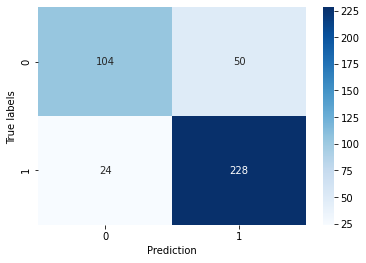

In [52]:
# normal
ret = run_experiment(dev_big, devtest_small, call_clean_text=True, 
                    clean_text_kws={'remove_punkt': True, 
                                    'remove_stopwords': True,
                                    'stem': True
                                   })
experiments['no_punkt_stopwords_stem'] = ret

Train accuray: 0.712000
Validation accuracy: 0.742000


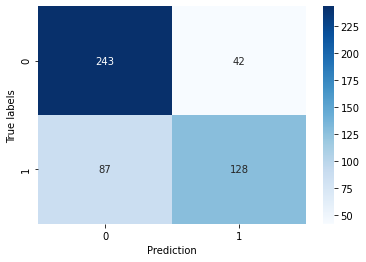

In [53]:
# hard
ret = run_experiment(dev_hard_big, devtest_hard_small, call_clean_text=True, 
                    clean_text_kws={'remove_punkt': True, 
                                    'remove_stopwords': True,
                                    'stem': True
                                   })
experiments['no_punkt_stopwords_stem_hard'] = ret

In [54]:
experiments.keys()

dict_keys(['baseline', 'baseline_hard', 'tokenized', 'tokenized_hard', 'big', 'big_hard', 'combined', 'combined_normal', 'combined_hard', 'no_punkt', 'no_punkt_hard', 'no_punkt_stopwords', 'no_punkt_stopwords_hard', 'stem_hard', 'no_punkt_stem', 'no_punkt_stopwords_stem', 'no_punkt_stopwords_stem_hard'])

In [59]:
# with open('output/experiments.pkl', 'wb') as f:
#     pickle.dump(experiments, f)

# Find best model

In [71]:
train_accus = []
val_accus = []
configs = []
datasets = []
for config in experiments:
    res = experiments[config]
    train_accus.append(res['train_accu'])
    val_accus.append(res['val_accu'])
    configs.append(config)
    if 'hard' in config:
        datasets.append('hard')
    else:
        datasets.append('normal')
result = pd.DataFrame({
    'config': configs,
    'dataset': datasets,
    'train_accu': train_accus,
    'val_accu': val_accus
})

In [72]:
# result.to_csv('output/mlp-results.csv', index=False)

In [73]:
result

,config,dataset,train_accu,val_accu
0,baseline,normal,0.841076,0.813665
1,baseline_hard,hard,0.725000,0.700000
2,tokenized,normal,0.844743,0.829814
3,tokenized_hard,hard,0.689000,0.668000
4,big,normal,0.842235,0.837438
5,big_hard,hard,0.681333,0.686000
6,combined,normal,0.690099,0.667770
7,combined_normal,normal,0.690099,0.812808
8,combined_hard,hard,0.690099,0.550000
9,no_punkt,normal,0.823336,0.852217


In [83]:
display(result.loc[[result.groupby('dataset').val_accu.idxmax().normal]])
display(result.loc[[result.groupby('dataset').val_accu.idxmax().hard]])

,config,dataset,train_accu,val_accu
13,no_punkt_stem,normal,0.833196,0.859606


,config,dataset,train_accu,val_accu
12,no_punkt_stopwords_hard,hard,0.712667,0.742


# Submission

In [160]:
# normal
best_model = experiments['no_punkt_stem']['model']
kws = {'remove_punkt': True, 'stem': True}
X = construct_features(test.line1.apply(clean_text, **kws), 
                       test.line2.apply(clean_text, **kws))
y_pred = best_model.predict(X)

In [161]:
submission = pd.DataFrame({
    'id': range(len(y_pred)),
    'Category': y_pred
})

In [162]:
submission.Category.value_counts()

1    1707
0    1293
Name: Category, dtype: int64

In [163]:
#submission.to_csv('output/submission.csv', index=False)

In [164]:
# hard
best_model = experiments['no_punkt_stopwords_stem_hard']['model']
kws = {'remove_punkt': True, 'remove_stopwords': True, 'stem': True}
X = construct_features(test_hard.line1.apply(clean_text, **kws), 
                       test_hard.line2.apply(clean_text, **kws))
y_pred = best_model.predict(X)
submission = pd.DataFrame({
    'id': range(len(y_pred)),
    'Category': y_pred
})
submission.Category.value_counts()

0    2046
1     954
Name: Category, dtype: int64

In [165]:
#submission.to_csv('output/submission-hard.csv', index=False)

# Error Analysis

In [129]:
model = experiments['big']['model']
kws = None
X = construct_features(devtest_small.line1.apply(clean_text, kws), 
                       devtest_small.line2.apply(clean_text, kws))
y_pred = model.predict(X)
mask_big = (devtest_small.is_paraphrase != y_pred)

In [138]:
model = experiments['no_punkt']['model']
kws = {'remove_punkt': True}
X = construct_features(devtest_small.line1.apply(clean_text, kws), 
                       devtest_small.line2.apply(clean_text, kws))
y_pred = model.predict(X)
mask_no_punkt = (devtest_small.is_paraphrase != y_pred)

In [139]:
err_big = devtest_small[mask_big]
err_no_punkt = devtest_small[mask_no_punkt]
len(err_big), len(err_no_punkt)

(66, 79)

In [140]:
# errors that the big model made but punkt didn't make
err_big[~err_big.index.isin(err_no_punkt.index)]

,line1,line2,is_paraphrase
370,You got your name in the paper,you have your name on paper.,1
674,What did I say my favorite kind of pizza was?,what's my favorite pizza?,1
724,"On September 22, 2004,","on September 22, 2004, the Ztracenipremier was...",1
119,She owns the Traders Hotel.,he's the owner of Traders Hotel.,1
525,"The big red button turned it on, therefore... ...",turn on the big red button...... and then........,1
814,No. Those aren't her eyes.,"no, it's not her eyes.",1
522,"Aside from the fact that he is gorgeous, charm...","besides being beautiful, charming, and she can...",1
178,"""Yvette is a council toady.","""Yvette is an asswipe of advice.",1
1,They're on the next flight home.,he's going home next flight.,1
218,"You have a nice night, Connie.","good night, Connie.",1


In [147]:
# errors that punkt made but big didn't make
err_no_punkt[~err_no_punkt.index.isin(err_big.index)]

,line1,line2,is_paraphrase
152,Can you fix radiators?,can I fix this for you?,0
561,"Hey, kid, you wanna hear a joke?",you wanna hear the truth?,0
164,"Oh, it's a rhetorical question, pal.","not a real question, rhetorical.",0
708,"I'm telling the truth, Doc.",I'm telling you.,0
112,We can't avoid the future.,that's a thing we can't avoid.,0
19,I didn't do anything more than that to you or ...,I don't want to be connected to you any more t...,0
54,What do you think Neal wants?,do you think what I think you think?,0
9,"And I'm fucked here, man.",and I'm fucked!,0
331,"I swear, I killed her.","and, uh... killed... I killed her.",0
156,"I swear it, I will.","I have nothing to swear on, but I swear it.",0


In [ ]:
# repeat for hard

In [148]:
model = experiments['big_hard']['model']
kws = None
X = construct_features(devtest_hard_small.line1.apply(clean_text, kws), 
                       devtest_hard_small.line2.apply(clean_text, kws))
y_pred = model.predict(X)
mask_big = (devtest_hard_small.is_paraphrase != y_pred)

In [149]:
model = experiments['no_punkt_stopwords_stem']['model']
kws = {'remove_punkt': True, 'remove_stopwords': True, 'stem': True}
X = construct_features(devtest_hard_small.line1.apply(clean_text, kws), 
                       devtest_hard_small.line2.apply(clean_text, kws))
y_pred = model.predict(X)
mask_no_punkt = (devtest_hard_small.is_paraphrase != y_pred)

In [150]:
err_big = devtest_hard_small[mask_big]
err_no_punkt = devtest_hard_small[mask_no_punkt]
len(err_big), len(err_no_punkt)

(157, 285)

In [152]:
# errors that the big model made but punkt didn't make
err_big[~err_big.index.isin(err_no_punkt.index)]

,line1,line2,is_paraphrase
178,This was recorded in two long inscriptions fro...,This was recorded in two long inscriptions fro...,1
249,Julio Junqueira was the first to be built in A...,Dr. Julio Junqueira was the first to be built ...,1
191,"That I lost , That I left .",That I have lost that I left .,1
452,Paula Mohamed Mostafa Shafiq ( born January 3 ...,Paula Mohamed Mostafa Shafiq ( born Nadia Lutf...,1
205,65 soldiers have been killed during the missio...,"During the mission , 65 soldiers were killed :...",1
...,...,...,...
347,The tournament was won by Joel Parkinson ( BRA...,The tournament was won by Joel Parkinson ( BRA...,1
274,Holly was musically influenced by Elton John .,Holly Holly was influenced by Elton John music...,1
109,"A peri , whose power appears in her hair , is ...",A Peri whose force appears in her hair is in E...,1
415,The song was written and produced by Gala comp...,The song was written and produced by the gala ...,1


In [153]:
# errors that punkt made but big didn't make
err_no_punkt[~err_no_punkt.index.isin(err_big.index)]

,line1,line2,is_paraphrase
132,"At the time of his death , David Cardinal Beat...",David Cardinal Beaton was Lord Chancellor of S...,0
731,Ahmad Yar Khan was born into the Tiwana family...,Sahib Khan was born into the Tiwana family of ...,0
754,Three brigades ( 11 Battalions ) were raised f...,Three brigades ( 11 battalions ) were trained ...,0
533,"In 1934 , two of them were produced , but no m...",Two were flown in 1934 but no more were produc...,0
266,"The agency has its headquarters in Paris , Fra...","The agency has its headquarters in Arlington ,...",0
...,...,...,...
89,The East Coast episode was filmed on site in N...,The Cabot Trail episode was filmed on location...,0
769,A biblical doom is a negative blessing in its ...,"A biblical damnation , in its most negative se...",0
620,He played Senior Intercounty Football with his...,He played with his local club Adrigole Gaelic ...,0
936,"It is centered on a stretch of the main road ,...","It is centered on a route of Brook Road , roug...",0
